In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import gensim.downloader as api

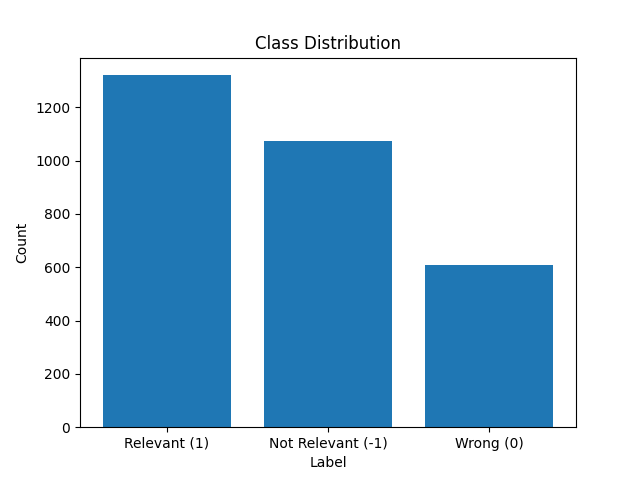

In [7]:
# Read the first Excel file
df1 = pd.read_excel('./Data/apple_tweets_devin_labeled.xlsx')

# Read the second Excel file
df2 = pd.read_excel('./Data/apple_tweets_hemanth_labeled.xlsx')

df3 = pd.read_excel('./Data/apple_tweets_nico_labeled.xlsx')

# Merge the two dataframes
df = pd.concat([df1, df2, df3], ignore_index=True)

# Make all Label = 0 to Label = -1 if not removing the @mentions
# df.loc[df['Label'] == 0, 'Label'] = -1

# Visualize the class distributions
class_counts = df['Label'].value_counts()
class_labels = ['Relevant (1)', 'Not Relevant (-1)', 'Wrong (0)']
# class_labels = ['Not Relevant', 'Relevant']
plt.figure()
plt.bar(class_labels, class_counts)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()


In [3]:
# Write the combined data to CSV if needed
# df.to_csv('combined_data_apple.csv', encoding='utf-8', index=False)

,Label,Text
0,1,They really have delayed it? http://www.apple....
1,0,@krisapple need to add a trends column in twee...
2,1,breaking news... the 3.0 update will be availa...
3,1,"So, #Apple are releasing #iPhone #3.0 software..."
4,1,@pollyesther att.probably not...but Apple gave...


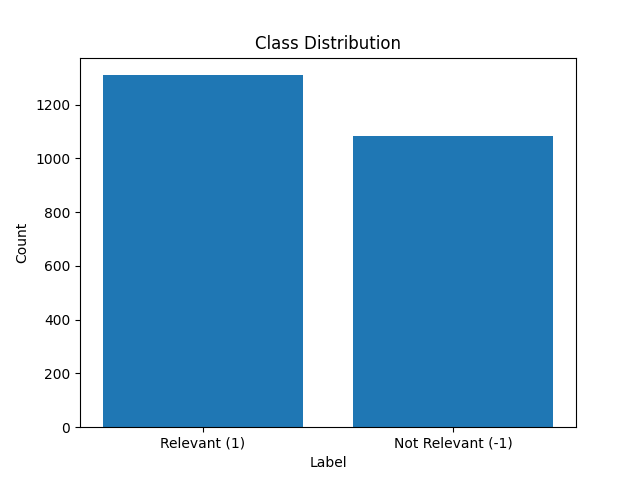

In [6]:
import re

df['Text'] = df['Text'].fillna('').astype(str)
# df['keyword'] = df['keyword'].fillna('').astype(str)

# Step 2: Define a function to check keyword occurrences
def check_keyword_occurrences(row):
    # keyword = row['keyword']
    keyword = 'apple'
    text = row['Text']
    # Create a regex pattern to find isolated occurrences of the keyword
    pattern = fr'\b{keyword}\b'  # '\b' is a word boundary in regex
    
    # Find all occurrences of the keyword
    all_occurrences = re.findall(pattern, text, flags=re.IGNORECASE)
    
    # Find all occurrences that are part of other strings like @mentions
    mention_occurrences = re.findall(fr'@\w*{keyword}\w*', text, flags=re.IGNORECASE)
    
    # Check if there are no isolated occurrences of the keyword
    # and at least one mention-like occurrence
    if len(all_occurrences) == 0 and len(mention_occurrences) > 0:
        return False  # Remove this row because keyword only appears in mentions
    return True  # Keep this row because keyword appears isolated or not in mentions at all


# Step 3: Filter the DataFrame
filtered_df = df[df.apply(check_keyword_occurrences, axis=1)]

# Step 4: Save the processed DataFrame
# filtered_df.to_csv('processed_file_apple.csv', index=False)

# Make 0s as -1
filtered_df.loc[filtered_df['Label'] == 0, 'Label'] = -1

class_counts = filtered_df['Label'].value_counts()
class_labels = ['Relevant (1)', 'Not Relevant (-1)']
# class_labels = ['Not Relevant', 'Relevant']
plt.figure()
plt.bar(class_labels, class_counts)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

In [8]:
# Comment this to run without @mention filtering.
df = filtered_df

In [9]:
# Feature extraction and SVC
# Load pre-trained word embeddings (word2vec)
word_vectors = api.load("word2vec-google-news-300")

def extract_features(text):
    if isinstance(text, str):
        tokens = text.lower().split()  # Tokenize and convert to lowercase
        word_embeddings = [word_vectors[token] for token in tokens if token in word_vectors]  # Get word embeddings
        return sum(word_embeddings) if word_embeddings else None  # Sum of word embeddings
    else:
        return None  # Return None for non-string inputs

df['Features'] = df['Text'].apply(extract_features)

# Remove rows with missing features
df = df.dropna()

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['Features'].tolist(), df['Label'], test_size=0.2, random_state=42)

# Train a Support Vector Classifier (SVC)
clf = SVC(kernel='linear')
clf.fit(X_train, y_train)

# Predictions
y_pred = clf.predict(X_test)

# Evaluation
print(classification_report(y_test, y_pred))


C:\Users\heman\AppData\Local\Temp\ipykernel_27876\951691778.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Features'] = df['Text'].apply(extract_features)


              precision    recall  f1-score   support

          -1       0.86      0.83      0.84       227
           1       0.85      0.87      0.86       252

    accuracy                           0.85       479
   macro avg       0.85      0.85      0.85       479
weighted avg       0.85      0.85      0.85       479

